## ❤️‍🩹 HEART DISEASE DETECTOR ◯


This database shows a set of information related to cardiac diseases, and a class representing if the subjects have or no any cardiac disease. 

Its importante to note that the database doesnt specify the disease, only if the subject haves it or not.


We consider this databse inespecific for diagnosis, but importance to determine WHAT coontributes most to any cardiac disease (Feature Importance) 😷

ref: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction/data


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier, Pool, cv, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, RocCurveDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import chi2_contingency
import scipy.stats as stats
import shap
import seaborn as sns
import plotly.express as px

from utils import *

In [4]:
# Reading the heart disease database

df = pd.read_csv("datasets/diabetes_prediction_dataset.csv")

Ok, what we have here? 🔎

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


We have features with "object" Dtype. We'll change this later to string to make possible to catboost use it.

How the data looks like? 🔎

In [6]:
# How the data looks like?
df.head(3)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0



Let's see if there's anything missing 🗃️

In [7]:
# Lets see if there is missing data..

missing_values_per_row = df.isnull().sum(axis=1)
num_rows_with_missing_data = (missing_values_per_row > 0).sum()
print(f'Rows with missing data (qty): {num_rows_with_missing_data}')


Rows with missing data (qty): 0


In [8]:
# Change the data type 'object' to 'string' in order to process the data.

for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = df[column].astype("string")

Analyzing numeric features with boxplot 🔢

In [14]:
categorical_string = ['gender','smoking_history']
numeric = ['age','bmi', 'HbA1c_level', 'blood_glucose_level']

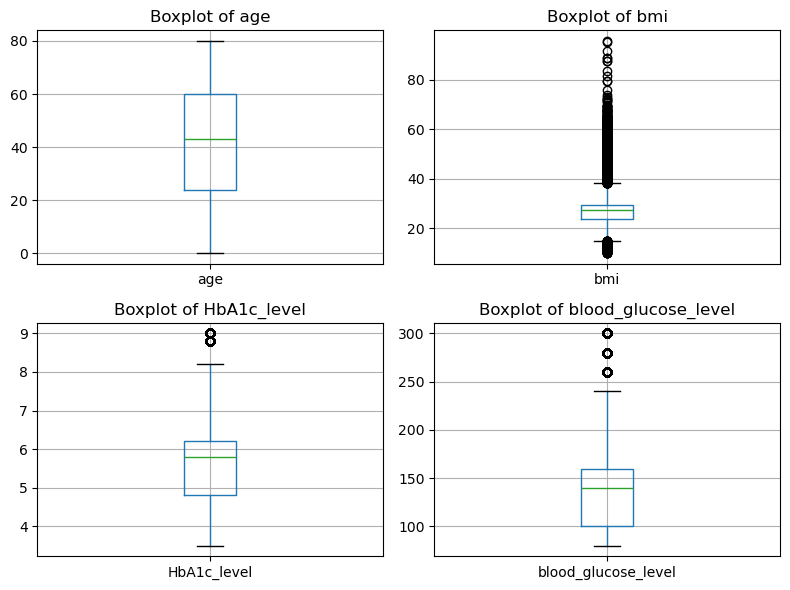

In [16]:
columns_to_plot = numeric

num_columns = len(columns_to_plot)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(8, 6))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

plt.tight_layout()

plt.show()


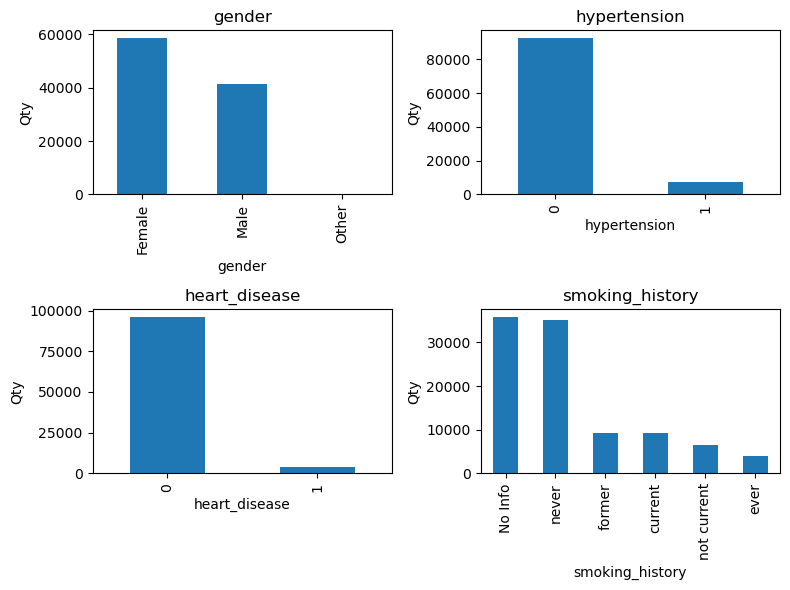

In [17]:
columns_to_plot = ['gender', 'hypertension', 'heart_disease', 'smoking_history']

num_columns = len(columns_to_plot)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(8, 6))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    counts = df[column].value_counts()
    counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Qty')

plt.tight_layout()

plt.show()

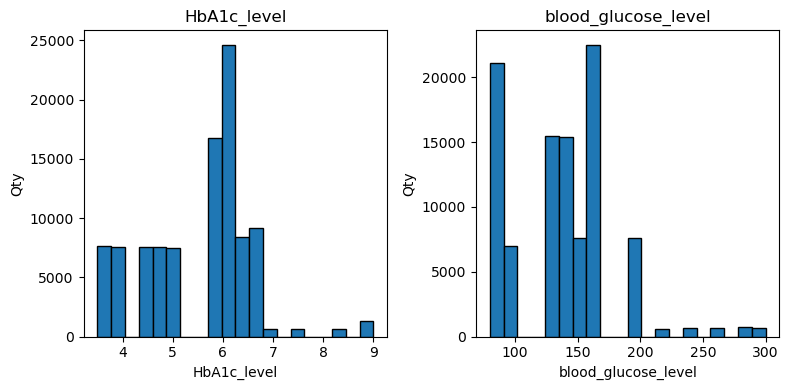

In [18]:
columns_to_plot = ['HbA1c_level', 'blood_glucose_level']

num_columns = len(columns_to_plot)
num_rows = (num_columns + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(8, 4))

axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    df[column].plot(kind='hist', ax=axes[i], bins=20, edgecolor='black')
    axes[i].set_title(column)
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Qty')

plt.tight_layout()
plt.show()


Except for FastingBS, all features have relatively equal distributions across quartiles. In FastingBS, the data is distributed closer to the median, wich is 0.

Analyzing categorical (string) features with bars 🔤

Notes:
 - Most of subjects base are cisgender man. 🤷🏻‍♂️
 - Classes (Heat Disease) are not unbalanced.

In [20]:
encoder = OneHotEncoder(sparse=False)

encoded_data = encoder.fit_transform(df[categorical_string])

encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_string))

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [27]:
df_encoded = pd.concat([encoded_df,df[numeric],df['diabetes']], axis = 1)

In [28]:
df_encoded 

,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age,bmi,HbA1c_level,blood_glucose_level,diabetes
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,80.0,25.19,6.6,140,0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,54.0,27.32,6.6,80,0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,27.32,5.7,158,0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,36.0,23.45,5.0,155,0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,76.0,20.14,4.8,155,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,80.0,27.32,6.2,90,0
99996,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,17.37,6.5,100,0
99997,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,66.0,27.83,5.7,155,0
99998,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,24.0,35.42,4.0,100,0


Checking if any of the numeric data are normally-distributed, in order to allow further analysis

In [29]:
normality_test(df_encoded , df_encoded.columns)

p-value may not be accurate for N > 5000.


,Coluna,p_valor,Normal?
0,gender_Female,0.0,False
1,gender_Male,0.0,False
2,gender_Other,0.0,False
3,smoking_history_No Info,0.0,False
4,smoking_history_current,0.0,False
5,smoking_history_ever,0.0,False
6,smoking_history_former,0.0,False
7,smoking_history_never,0.0,False
8,smoking_history_not current,0.0,False
9,age,0.0,False


Not normally-distributed data here.

Now we'll see if there is significant differences between the data of the classes.

In [31]:
df_class_0 = df_encoded[df_encoded['diabetes'] == 0]
df_class_1 = df_encoded[df_encoded['diabetes'] == 1]

differences_test(df_class_0, df_class_1, df_encoded.columns)

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.


,Coluna,p_valor,Different?
0,gender_Female,1.517997e-32,False
1,gender_Male,9.860755e-33,False
2,gender_Other,1.959368e-01,True
3,smoking_history_No Info,0.000000e+00,False
4,smoking_history_current,5.634715e-10,False
5,smoking_history_ever,2.619831e-14,False
6,smoking_history_former,1.636498e-211,False
7,smoking_history_never,6.463554e-18,False
8,smoking_history_not current,5.483437e-11,False
9,age,0.000000e+00,False


The numeric data are not statistically different between classes. Here is a attention point to the modelling quality.

Searching for similarities between categorical features

In [32]:
contingency_table = pd.DataFrame()

for column in df.columns:
    if df[column].dtype == 'string':
        contingency_table = pd.crosstab(df[column], df.index, rownames=[column])

chi2, p, _, _ = chi2_contingency(contingency_table)

print(f"Chi-Square Statistics: {chi2}")
print(f"p_value: {p}")

alpha = 0.05  
if p < alpha:
    print("There is a statistically significant association between the variables.")
else:
    print("There is NO statistically significant association between the variables.")

Chi-Square Statistics: 500000.0
p_value: 0.4977393347182003
There is NO statistically significant association between the variables.


The categorical data being not associated it's a good signal for the modelling!

Finally, lets see if the numerica data are correlated.

In [38]:
df_encoded.corr()

,gender_Female,gender_Male,gender_Other,smoking_history_No Info,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age,bmi,HbA1c_level,blood_glucose_level,diabetes
gender_Female,1.000000,-0.999629,-0.015948,-0.053810,-0.026517,-0.011019,-0.048927,0.098682,0.011419,0.030480,0.023016,-0.020015,-0.017200,-0.037553
gender_Male,-0.999629,1.000000,-0.011285,0.053833,0.026636,0.010991,0.049048,-0.098547,-0.011985,-0.030282,-0.023021,0.020058,0.017189,0.037666
gender_Other,-0.015948,-0.011285,1.000000,-0.000695,-0.004293,0.001062,-0.004310,-0.005181,0.020760,-0.007348,0.000119,-0.001528,0.000457,-0.004090
smoking_history_No Info,-0.053810,0.053833,-0.000695,1.000000,-0.239002,-0.152562,-0.239938,-0.549299,-0.196099,-0.276945,-0.222553,-0.045979,-0.051635,-0.118939
smoking_history_current,-0.026517,0.026636,-0.004293,-0.239002,1.000000,-0.065343,-0.102766,-0.235267,-0.083990,0.030946,0.053617,0.006123,0.012447,0.019606
smoking_history_ever,-0.011019,0.010991,0.001062,-0.152562,-0.065343,1.000000,-0.065598,-0.150177,-0.053613,0.065768,0.044343,0.009655,0.006267,0.024080
smoking_history_former,-0.048927,0.049048,-0.004310,-0.239938,-0.102766,-0.065598,1.000000,-0.236187,-0.084319,0.216481,0.111312,0.037306,0.040688,0.097917
smoking_history_never,0.098682,-0.098547,-0.005181,-0.549299,-0.235267,-0.150177,-0.236187,1.000000,-0.193034,0.065498,0.086849,0.010684,0.012475,0.027267
smoking_history_not current,0.011419,-0.011985,0.020760,-0.196099,-0.083990,-0.053613,-0.084319,-0.193034,1.000000,0.067663,0.034979,0.009830,0.008613,0.020734
age,0.030480,-0.030282,-0.007348,-0.276945,0.030946,0.065768,0.216481,0.065498,0.067663,1.000000,0.337396,0.101354,0.110672,0.258008


In [53]:
# Calculating and ranking the max correlation between features

correlation_matrix = df_encoded.corr()

mean_correlation = {}

for coluna in correlation_matrix.columns:
    mean_corr = correlation_matrix[coluna].drop(coluna).mean()
    mean_correlation[coluna] = mean_corr

mean_corr_df = pd.DataFrame(list(mean_correlation.items()), columns=['Column/Feature', 'Max Correlation'])

mean_corr_df = mean_corr_df.sort_values(by='Max Correlation', ascending=False)

print("Ranking columns/features by max correlation")
print(mean_corr_df)

Ranking columns/features by max correlation
                 Column/Feature  Max Correlation
13                     diabetes         0.104559
9                           age         0.074592
10                          bmi         0.064206
12          blood_glucose_level         0.062886
11                  HbA1c_level         0.059837
2                  gender_Other        -0.002483
6        smoking_history_former        -0.017638
5          smoking_history_ever        -0.025857
8   smoking_history_not current        -0.034542
4       smoking_history_current        -0.046754
1                   gender_Male        -0.073795
0                 gender_Female        -0.082079
7         smoking_history_never        -0.089711
3       smoking_history_No Info        -0.161048


No important correlation here! 

Starting the modelling process using CatBoost 😸

In [169]:
X = df.drop('diabetes', axis = 1)
y = df['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
len(y_train)/(2 * np.bincount(y_train)[1])

#np.bincount(y_train)[1]

5.889281507656066

In [125]:
# Calculating scale_pos_weight
weight = len(df[df['diabetes']==0]) / len(df[df['diabetes']==1])
print(weight)

10.764705882352942


In [117]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

print(np.round(class_weights))


[1. 6.]


In [175]:

categorical_features = ['gender','smoking_history']

model = CatBoostClassifier(iterations=200, 
                           depth=5, 
                           learning_rate=0.01, 
                           cat_features=categorical_features, 
                           early_stopping_rounds=10,
                           random_seed=42,
                           custom_loss=['AUC', 'Accuracy'],
                           #scale_pos_weight=11,
                           #class_weights=class_weights,
                           class_weights={0: 0, 1: 11}
                           #auto_class_weights = ['balanced']
                           )

model.fit(
    X_train, 
    y_train,
    eval_set=(X_test, y_test),
    verbose=True,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6491187	test: 0.6490399	best: 0.6490399 (0)	total: 220ms	remaining: 43.8s
1:	learn: 0.6047689	test: 0.6045326	best: 0.6045326 (1)	total: 353ms	remaining: 34.9s
2:	learn: 0.5641634	test: 0.5638745	best: 0.5638745 (2)	total: 467ms	remaining: 30.7s
3:	learn: 0.5256625	test: 0.5253112	best: 0.5253112 (3)	total: 574ms	remaining: 28.1s
4:	learn: 0.4896822	test: 0.4891601	best: 0.4891601 (4)	total: 665ms	remaining: 25.9s
5:	learn: 0.4573231	test: 0.4567930	best: 0.4567930 (5)	total: 756ms	remaining: 24.5s
6:	learn: 0.4263956	test: 0.4258357	best: 0.4258357 (6)	total: 823ms	remaining: 22.7s
7:	learn: 0.3944229	test: 0.3938909	best: 0.3938909 (7)	total: 878ms	remaining: 21.1s
8:	learn: 0.3680965	test: 0.3675445	best: 0.3675445 (8)	total: 1s	remaining: 21.3s
9:	learn: 0.3435575	test: 0.3430967	best: 0.3430967 (9)	total: 1.11s	remaining: 21.1s
10:	learn: 0.3191942	test: 0.3187843	best: 0.3187843 (10)	total: 1.25s	remaining: 21.5s
11:	learn: 0.2971934	test: 0.2967699	best: 0.2967699 (1

Make predictions over test data 🔮

Fingers-crossed: How the model performed?

In [176]:
y_pred = model.predict(X_test)

metrics_df = pd.DataFrame(columns=['Accuracy', 'F1-Score', 'Recall', 'Precision', 'AUC-ROC'])

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division = np.nan)
auc_roc = roc_auc_score(y_test, y_prob)
metrics_df = metrics_df._append({
    'Accuracy': accuracy,
    'F1-Score': f1,
    'Recall': recall,
    'Precision': precision,
    'AUC-ROC': auc_roc}, ignore_index=True)

metrics_df

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,Accuracy,F1-Score,Recall,Precision,AUC-ROC
0,0.0854,0.157361,1.0,0.0854,0.813051


In [177]:
from collections import Counter

print (Counter(y_pred))
print(Counter(y_test))


Counter({1: 20000})
Counter({0: 18292, 1: 1708})


is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


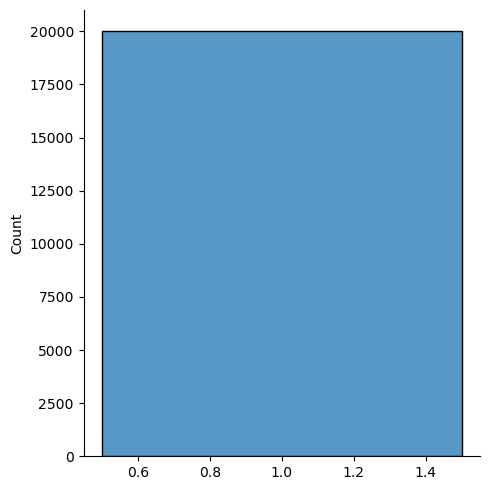

In [178]:
sns.displot(y_pred)

In [168]:
y_prob.max()

0.01725376377955817

In [156]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[18292,     0],
       [ 1708,     0]])

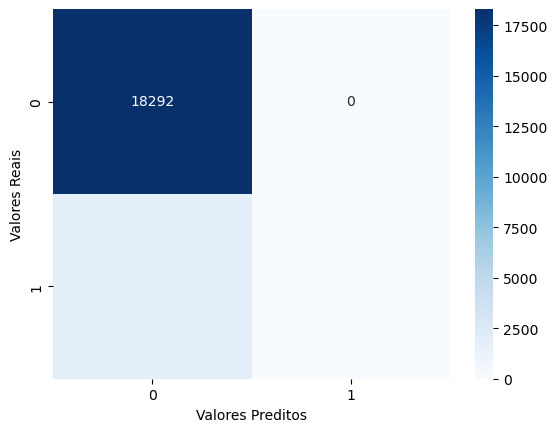

In [157]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Valores Preditos')
plt.ylabel('Valores Reais')
plt.show()

🎉 The CatBoost model trained for heart disease classification demonstrated <b>solid performance</b> on both training and validation sets. 
With an accuracy of approximately 86.41%, the model correctly classified the majority of samples in the validation set. 

⭐ Furthermore, the model achieved an F1-Score of around 0.8815, highlighting its ability to balance precision and recall. The recall of approximately 86.92% indicates the model's ability to identify cases of heart disease, while the accuracy of approximately 89.42% demonstrates that the positive predictions are reliable.

🤩 The AUC-ROC metric, with a value of around 0.92754, reflects the high discriminatory capacity of the model. In summary, the CatBoost model is effective in classifying heart diseases, with high performance in identifying positive cases and a solid ability to discriminate between classes.

Determining what's the importance (weight) of each feature in detecting heart disease. 

In [158]:
feature_importances = model.get_feature_importance(prettified=True)
feature_importances

,Feature Id,Importances
0,blood_glucose_level,26.210370
1,HbA1c_level,20.939041
2,hypertension,18.658391
3,heart_disease,15.446039
4,age,10.675282
5,bmi,8.070877
6,gender,0.000000
7,smoking_history,0.000000


<Axes: ylabel='Feature Id'>

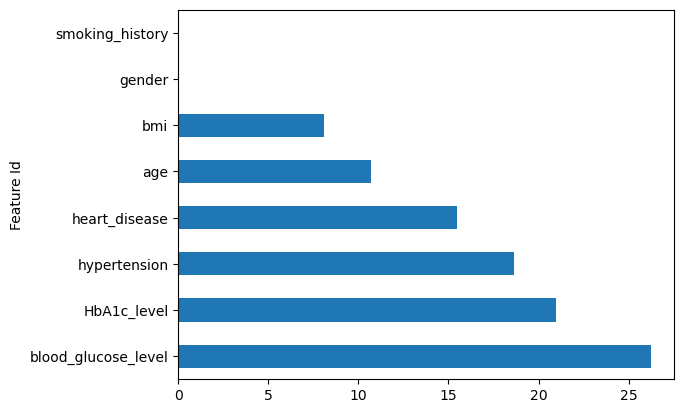

In [159]:
feature_importances.plot(kind='barh', x='Feature Id', y='Importances', legend=False)

We can see that, and attention to: 
 - ST_Slope: Can be checked with ECG exam: ref: https://pubmed.ncbi.nlm.nih.gov/3739881/
 - ChestPainType: Always keep in mind and tell your doctor the type of chest pain you're feeling.
 - ExerciseAngina: Chest pain during exercises is a good teller of heart disease.
 - Cholesterol: Keep your blood exams updated and consult your doctor on how to improve your feeding habits.


No negative samples in y_true, false positive value should be meaningless


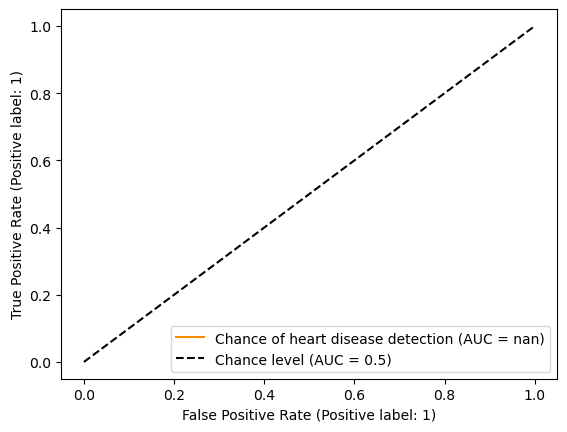

In [148]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(
    y_pred,
    y_test,
    name=f"Chance of heart disease detection",
    color="darkorange",
    plot_chance_level=True)
   

In [149]:
print(model.get_best_score())

{'learn': {'Accuracy:use_weights=true': 1.0, 'Logloss': 0.00011328639176509004, 'Accuracy:use_weights=false': 0.093075}, 'validation': {'Accuracy:use_weights=true': 1.0, 'Logloss': 0.0001043303609036875, 'Accuracy:use_weights=false': 0.09375, 'AUC': 0.8626840971930243}}


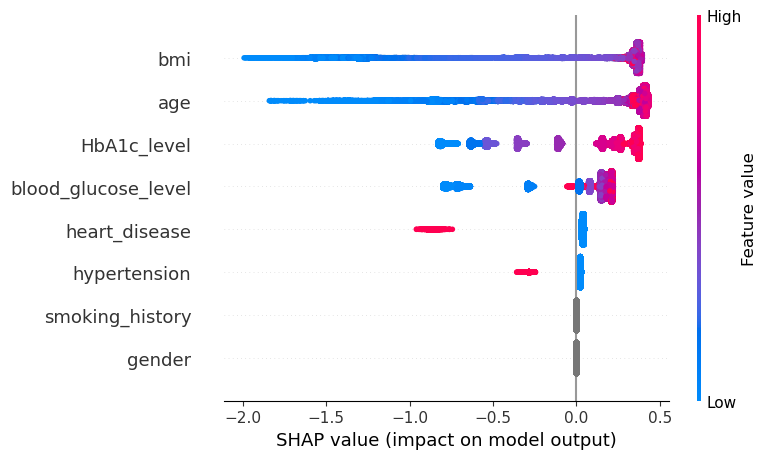

In [150]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

Notes over SHAP:
 - ST_Slope, ChestPainType and ExerciseAngina can produce equally positive and negative impacts in the model results.
 - Cholesterol impacts more positivelly in the model, meaning that when the cholesterol it's high, it impacts, but when its low, compared to the others, its a lesser impact.


<b>Conclusion:</b>

The heart disease classification project using CatBoost revealed promising results. Feature importance analysis highlighted the importance of features such as ST_Slope, ChestPainType, ExerciseAngina and Cholesterol in predicting heart disease. These findings provide valuable insights to guide clinical assessment and patient awareness. With an accuracy of approximately 86.41% and an AUC-ROC of approximately 0.92754, the model demonstrates high performance in identifying cardiac cases. These metrics, along with feature interpretation, highlight the model's potential as a valuable tool to assist healthcare professionals in the early detection and treatment of heart disease.

___

In [179]:

X_enc = df_encoded.drop('diabetes', axis = 1)
y_enc = df_encoded['diabetes']

X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, test_size=0.2, random_state=42)

In [181]:
model_encoded = CatBoostClassifier(iterations=200, 
                           depth=5, 
                           learning_rate=0.01, 
                           early_stopping_rounds=10,
                           random_seed=42,
                           custom_loss=['AUC', 'Accuracy'],
                           #scale_pos_weight=11,
                           #class_weights=class_weights,
                           class_weights={0: 0, 1: 11}
                           #auto_class_weights = ['balanced']
                           )

model_encoded.fit(
    X_train_enc, 
    y_train_enc,
    eval_set=(X_test_enc, y_test_enc),
    verbose=True,
    plot=True
    )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6468490	test: 0.6469028	best: 0.6469028 (0)	total: 41.7ms	remaining: 8.29s
1:	learn: 0.6053518	test: 0.6054547	best: 0.6054547 (1)	total: 70.3ms	remaining: 6.96s
2:	learn: 0.5632458	test: 0.5633608	best: 0.5633608 (2)	total: 120ms	remaining: 7.87s
3:	learn: 0.5243308	test: 0.5244149	best: 0.5244149 (3)	total: 162ms	remaining: 7.92s
4:	learn: 0.4890450	test: 0.4889589	best: 0.4889589 (4)	total: 198ms	remaining: 7.7s
5:	learn: 0.4577560	test: 0.4577312	best: 0.4577312 (5)	total: 222ms	remaining: 7.17s
6:	learn: 0.4266876	test: 0.4266287	best: 0.4266287 (6)	total: 236ms	remaining: 6.5s
7:	learn: 0.3967828	test: 0.3966739	best: 0.3966739 (7)	total: 254ms	remaining: 6.1s
8:	learn: 0.3703235	test: 0.3702095	best: 0.3702095 (8)	total: 329ms	remaining: 6.98s
9:	learn: 0.3441693	test: 0.3440326	best: 0.3440326 (9)	total: 355ms	remaining: 6.75s
10:	learn: 0.3194071	test: 0.3192489	best: 0.3192489 (10)	total: 390ms	remaining: 6.7s
11:	learn: 0.2965002	test: 0.2963516	best: 0.2963516 (

In [ ]:
y_pred_enc = model.predict(X_test)

metrics_df_enc = pd.DataFrame(columns=['Accuracy', 'F1-Score', 'Recall', 'Precision', 'AUC-ROC'])

y_pred = model_encoded.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] 

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division = np.nan)
auc_roc = roc_auc_score(y_test, y_prob)
metrics_df = metrics_df._append({
    'Accuracy': accuracy,
    'F1-Score': f1,
    'Recall': recall,
    'Precision': precision,
    'AUC-ROC': auc_roc}, ignore_index=True)

metrics_df